#### using transfer learning for the segementation job

In [1]:
import torch

print(torch.cuda.is_available())

True


/home/li52/.conda/envs/seg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

print(tf.__version__)

2.6.2


In [3]:
print(tf.__file__)

/home/li52/.conda/envs/seg/lib/python3.7/site-packages/tensorflow/__init__.py


In [4]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32503955456
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 1576174893171335819
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0"



2022-05-19 16:34:53.801938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 16:34:54.392858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


[None]

define the neptune for documenting

In [5]:
# define if the documenting process should go on

DOCUMENT = True
TRAIN = 50  # training epochs num


In [6]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-Unet",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["transfer", "vgg16", "val", "test", "epochs:50"])


https://app.neptune.ai/leeleeroy/LM-2D-Unet/e/LMDUN-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home/li52/.conda/envs/seg/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.conda/envs/seg/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


In [7]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

#### Load data in

In [8]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial/'

Mask = np.load(PATH + 'fMax.npy')
IMG = np.load(PATH + 'rawIMG.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)

print('Mask shape: ', Mask.shape)
print('Image shape: ', IMG.shape)

Mask shape:  (380, 1040, 1392)
Image shape:  (380, 1040, 1392)


In [9]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

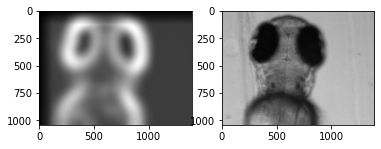

In [10]:
# sanity check

tMask = Mask[0,...]
tIMG = IMG[0,...]

plt.subplot(1,2,1)
plt.imshow(tMask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(tIMG, cmap='gray')
plt.show()

In [11]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [12]:
# due to the huge data amount, use part of the images for the training 
from skimage.transform import resize

size = [256*(IMG.shape[1]//256), 256*(IMG.shape[2]//256)]
numIMG = 30
smallIMG = resize(IMG[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)
smallMask = resize(Mask[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)

In [13]:
print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print(np.max(smallIMG), np.min(smallIMG))
print(np.max(smallMask), np.min(smallMask))

img: (30, 1024, 1280) float64
mask: (30, 1024, 1280) float64
0.3625603170955914 0.0
0.8549019607843137 0.0


In [14]:
# prepare the test dataset
NUM1 = 51
NUM2 = 55

testIMG = resize(IMG[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)
testMask = resize(Mask[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)

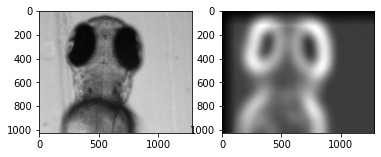

img: (30, 1024, 1280) float64
mask: (30, 1024, 1280) float64
img range: 0.3625603170955914 0.0
mask range: 0.8549019607843137 0.0


In [15]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [16]:
# preporcessing the data

from patchify import patchify, unpatchify


# train dataset
THRESHOLD = 0.5
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)


In [17]:
print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)

patches shape: (600, 256, 256, 3) float64
mask shape: (600, 256, 256, 1) float64


In [18]:
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

0.3176470588235294 0.0
0.16724034926470593 0.04524509803921533


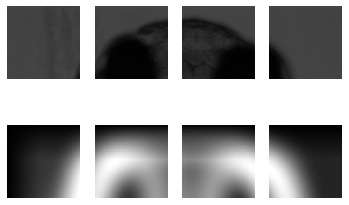

In [19]:
#  sanity check for the mask and images

IMG_test = X_patches
GT_test = Y_masks

startNum = 100
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(IMG_test[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(GT_test[int(i+startNum)], cmap='gray')    
plt.show()



#### prepare the models

In [20]:
# usinng pre-trained weight

import tensorflow
import tensorflow.keras

import segmentation_models as sm

# from keras_applications.resnet import ResNetV2

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [21]:
# preprocessing the data

# preprocess input
images = X_patches; masks = Y_masks;
images = preprocess_input(images)
# print(images1.shape)  # come with packed toolset

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)


In [22]:
print('training data:', X_train.shape, Y_train.shape)
print('validation data:', X_val.shape, Y_val.shape )

training data: (450, 256, 256, 3) (450, 256, 256, 1)
validation data: (150, 256, 256, 3) (150, 256, 256, 1)


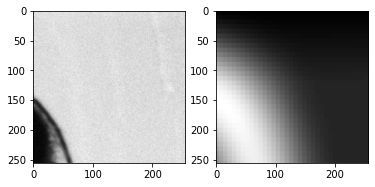

In [23]:
#Sanity check for training dataset. view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))

subShow(X_train[image_number, :,:, 0], Y_train[image_number])

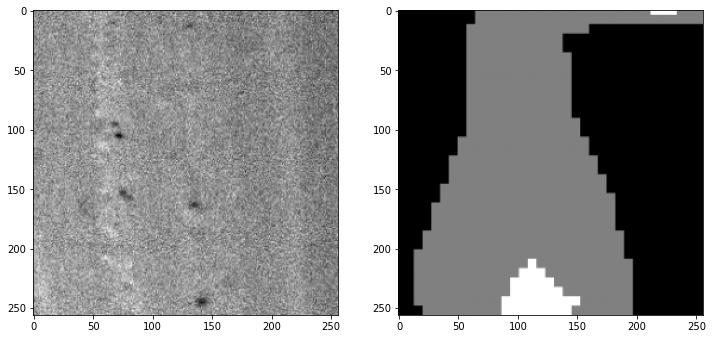

In [24]:
#Sanity check for testing dataset, view few mages

image_number = random.randint(0, len(X_val))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_val[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_val[image_number], (256, 256)), cmap='gray')
plt.show()

In [25]:
# data generator

seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add data augmentaton strategy
img_data_gen_args = dict(rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
                     fill_mode='reflect',)
                     #preprocessing_function = lambda x: np.where(x>0.1, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(Y_val, seed=seed)

In [26]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [27]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

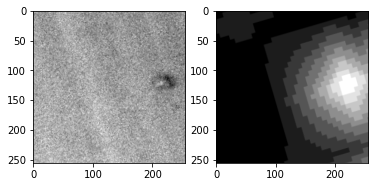

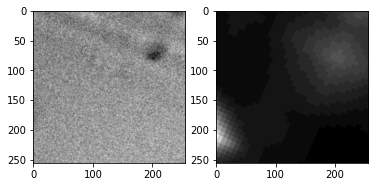

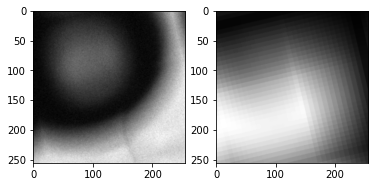

In [28]:
# sanity check in the generator size 0-31

for i in range(28,31):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [29]:
# define model

import segmentation_models as sm

sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
# print(model.summary())

2022-05-19 16:35:14.618229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [ ]:
#Fit the model and train

import tensorflow.keras as k

callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=100, callbacks = callbacks)

2022-05-19 16:35:15.832258: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-19 16:35:15.832426: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-19 16:35:15.832482: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-19 16:35:15.832907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /trinity/shared/pkg/devel/julia/1.7.2/lib:/trinity/shared/pkg/analysis/root/6.16.00/lib:/trinity/shared/pkg/analysis/root/6.16.00/lib/root:/trinity/shared/pkg/analysis/octave/5.1.0/lib:/trinity/shared/pkg/numlib/fftw/3.3.8/gcc/7.3.0/lib:/trinity/shared/pkg/numlib/lapack/3.8.0/gcc/7.3.0/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib:/trinity/shared/pkg/numlib/mpfr/3.1.4/lib:

Epoch 1/100


2022-05-19 16:35:21.034411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 1/50 [..............................] - ETA: 6:20 - loss: 1.4888 - iou_score: 0.2475

2022-05-19 16:35:24.516339: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-19 16:35:24.516377: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/50 [>.............................] - ETA: 37s - loss: 1.4773 - iou_score: 0.2371 

2022-05-19 16:35:25.210630: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-19 16:35:25.214550: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-19 16:35:25.346723: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1330 callback api events and 1327 activity events. 
2022-05-19 16:35:25.393312: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-19 16:35:25.452181: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./Unet/tensorBoard/train/plugins/profile/2022_05_19_16_35_25

2022-05-19 16:35:25.482186: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./Unet/tensorBoard/train/plugins/profile/2022_05_19_16_35_25/gv001.cluster.trace.json.gz
2022-05-19 16:35:25.559128: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Crea

50/50 [==============================] - 76s 1s/step - loss: 1.3030 - iou_score: 0.2601 - val_loss: 7.0076 - val_iou_score: 0.2634
Epoch 2/100
50/50 [==============================] - 48s 986ms/step - loss: 1.2740 - iou_score: 0.2677 - val_loss: 2.2510 - val_iou_score: 0.0331
Epoch 3/100
50/50 [==============================] - 48s 973ms/step - loss: 1.2786 - iou_score: 0.2621 - val_loss: 1.6213 - val_iou_score: 0.0804
Epoch 4/100
50/50 [==============================] - 48s 983ms/step - loss: 1.2792 - iou_score: 0.2618 - val_loss: 1.4471 - val_iou_score: 0.1522
Epoch 5/100
50/50 [==============================] - 66s 1s/step - loss: 1.2664 - iou_score: 0.2773 - val_loss: 1.6096 - val_iou_score: 0.0803
Epoch 6/100
50/50 [==============================] - 48s 976ms/step - loss: 1.2644 - iou_score: 0.2732 - val_loss: 4.8650 - val_iou_score: 0.2609
Epoch 7/100
50/50 [==============================] - 66s 1s/step - loss: 1.2711 - iou_score: 0.2678 - val_loss: 1.4447 - val_iou_score: 0.1452

In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()
plt.savefig('loss.png')

In [ ]:
# save model as local

model.save("./Unet/model/Unet2D_transfer_resnet_noAug.h5")

#### test the images

In [ ]:
# from segmentation_models.losses  import bce_jaccard_loss
# from segmentation_models.metrics import IOUScore
# # from tensorflow import keras
# from keras.models import load_model

# model = load_model(
#     "./Unet/model/Unet2D_transfer_resnet.h5", 
#     custom_objects={
#         'binary_crossentropy + jaccard_loss': bce_jaccard_loss,
#         'iou_score': IOUScore(),
#     }
# )

In [ ]:
from keras.models import load_model

model = load_model("./Unet/model/Unet2D_transfer_resnet_noAug.h5", compile=False)  # some self-defined loss should be loaded by segmentation_models

In [ ]:
# prepare the test dataset
NUM1 = 51
NUM2 = 65

testIMG = resize(IMG[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True) # only takes 5 images from the raw databank
testMask = resize(Mask[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)

unpatchPara = testIMG[0].shape

In [ ]:
# test on bigger image
from patchify import patchify, unpatchify

imagePred = []

for i in range(testIMG.shape[0]):
    tIMG = np.expand_dims(testIMG[i,...], axis=0)
    tPatch, _ = rawPatch(tIMG, patchPara)
    tPatch = np.stack((tPatch,)*3, axis=-1)
    tPatch = preprocess_input(tPatch)
    tPred = model.predict(tPatch)
    imgPred = np.reshape(tPred[...,0], (4, 5, 256, 256))
    imgPred = unpatchify(imgPred, unpatchPara)
    imagePred.append(imgPred)
    
imagePred = np.asarray(imagePred)

In [ ]:
NUM = 8

subShow(imagePred[NUM,...], testMask[NUM,...])